In [1]:
"Assignment 2 - ANFIS for classification problem"

import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas
import sys

In [2]:
"Import datasets for both problems"

#binary classification dataset
data_b = datasets.fetch_openml("diabetes",version=1, as_frame=True)

#regression dataset
data_r = datasets.load_diabetes(as_frame=True)

#user input to select the dataset/task
task = input("Choose binary (b) or regression (r) dataset: ")

if task == "b":
    data = data_b
    y = data.target.map({'tested_negative': 0, 'tested_positive': 1}).values #convert the text data to binary
elif task == "r":
    data = data_r
    y = data.target.values
else:
    sys.exit()

X = data.data.values

#verifying the data
print(X.shape)
#print(X)
#print(y.shape)
#print(y)


(768, 8)


In [3]:
"Train test spliting"
#choosing the percentage of data used for testing 
#and spliting the train and test data into different variables

test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)


In [ ]:
"Standardizing the features"
#each feature will have mean=0 and std=1
#improves numerical stability and distance-based methods

scaler=StandardScaler()
Xtr = scaler.fit_transform(Xtr)
Xte = scaler.transform(Xte)

In [5]:
"Fuzzy C-Means (FCM) clustering"

#defining the number of clusters
n_clusters = 2
#defining the fuzzification coefficient 
m = 2

#concatenate target for clustering (only for regression problems)
Xexp = np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)

#transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

#fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

print("Cluster centers shape:", centers.shape)


Cluster centers shape: (2, 9)


In [6]:
"Compute sigma (spread) for each cluster"

sigmas = []
for j in range(n_clusters):
    #membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    #weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

#the sigmas define the Gaussian width for each input feature
#they control how strongly each sample activates a fuzzy rule


Fuzzy partition coefficient (FPC): 0.5049408015137152


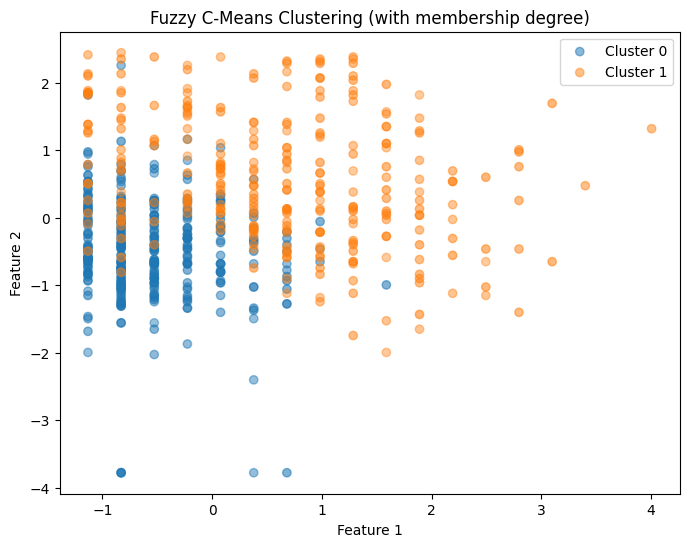

In [7]:
"Hard clustering from fuzzy membership"

cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

#plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             #feature 1
        Xexp[cluster_labels == j, 1],             #feature 2
        alpha=u[j, :],          #transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


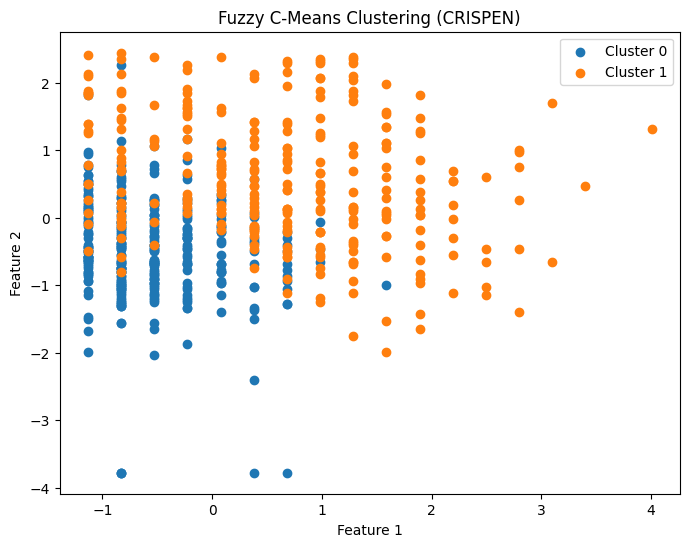

In [8]:
"Plot first two features with cluster assignments"
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


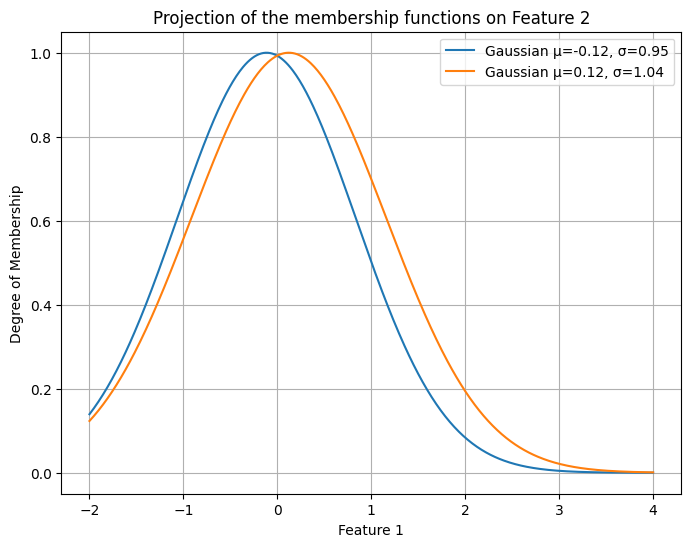

In [9]:

"Gaussian formula"
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux = []
feature = 0 #feature index for visualization
for j in range(n_clusters):
    #compute Gaussian curves
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))
    #plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,feature],2)}, σ={np.round(sigmas[j,feature],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# ---------------------------
" Gaussian Membership Function "
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


In [11]:
# ---------------------------
" TSK Model "
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs




In [12]:
# ---------------------------
" Least Squares Solver for Consequents (TSK) "
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)


In [13]:
# ---------------------------
" Gradient Descent Training "
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()


In [14]:
# ---------------------------
" Hybrid Training (Classic ANFIS) "
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True


This cell defines the ANFIS algorithm and it uses the Least Squares (for computing the optimal consequents) and the Gradient Descent (for updating membership functions) training functions.

The inputs for this function are:

model – TSK model that contains MFs (membership function parameters, i.e., antecedents) and consequents (linear coefficients in the rules)

X – The input data (features)

y – The target outputs

max_iters – How many times the hybrid process (GD + LS) is repeated

gd_epochs – Number of gradient descent steps per iteration

lr – Learning rate for the gradient descent step

In [15]:
# ---------------------------
" Alternative Hybrid Training (LS+ gradient descent on all)"
# ---------------------------
def train_hybrid(model, X, y, epochs=100, lr=1e-4):
    # Step 1: LS for consequents
    train_ls(model, X, y)
    # Step 2: GD fine-tuning
    train_gd(model, X, y, epochs=epochs, lr=lr)


This cell defines an alternative ANFIS training approach where the model is trained in two steps: first, the consequents are computed using Least Squares (LS), and then the entire model (both antecedents and consequents) is fine-tuned using Gradient Descent (GD).

The inputs for this function are:

model – TSK model that contains MFs (membership function parameters, i.e., antecedents) and consequents (linear coefficients in the rules)

X – The input data (features)

y – The target outputs

epochs – Number of gradient descent steps for fine-tuning

lr – Learning rate for the gradient descent step

In [16]:
"Build TSK model for regression"

#create TSK model using input size, number of rules, centers and sigmas from clustering
model = TSK(
    n_inputs=Xtr.shape[1],  #number of features
    n_rules=n_clusters,     #number of fuzzy rules
    centers=centers[:,:-1], #ignore target dimension for antecedents
    sigmas=sigmas[:,:-1])

#convert datasets to PyTorch tensors
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


In [24]:
"Training with hybrid ANFIS"
    
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1), max_iters = 20, gd_epochs = 20, lr = 1e-3)


tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1338, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1338, grad_fn=<MseLossBackward0>)
tensor(0.1338, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.1338, grad_fn=<MseLossBackward0>)
tensor(0.1337, grad_fn=<MseLossBackward0>)
tensor(0.13

This time the training is done with ANFIS.

In [28]:
y_pred, _, _=model(Xte)

In [29]:

"Performance metrics: Accuracy for classification problem and MSE for regression"

if task == "b":
    print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
elif task == "r":
    print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression
else:
    sys.exit()




ACC:0.7337662337662337
